In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import pdb
from copy import deepcopy


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed(0)

Using device: cuda


In [3]:
class MLP(nn.Module):

    def __init__(self, num_classes, in_dim, context_dim, h, out_dim):
        super(MLP, self).__init__()
        # Add class conditioned lookup table
        self.embedding_table = nn.Embedding(num_classes + 1, in_dim + context_dim)
        # self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.embedding_table.weight.data.normal_(0, 1)
        # Create diffusion network
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        return self.network(x_t_by_c)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1 = dist1
        self.dist2 = dist2
        assert self.dist1.shape == self.dist2.shape

    def __len__(self):
        return self.dist1.shape[0]

    def __getitem__(self, idx):
        return self.dist1[idx], self.dist2[idx]


def sample_multimodal_distribution(modes, std, batch_size=1000):
    dataset = []
    for i in range(batch_size):
        sample = np.random.randn(modes.shape[1]) * std
        mode_idx = np.random.randint(modes.shape[0])
        sample[0] += modes[mode_idx, 0]
        sample[1] += modes[mode_idx, 1]
        instance = np.concatenate((sample, np.array([mode_idx])))
        dataset.append(instance)
    return np.array(dataset, dtype="float32")


def class_conditioned_sampling(labels):
    bsz = labels.shape[0]
    mask = ~(labels[None] == labels[:, None])
    # choices[mask] = -1 # remove self-sampling
    # Now randomly sample from the remaining choices
    weights = mask.float()
    weights_sum = weights.sum(dim=1, keepdim=True)
    if (weights_sum == 0).any():
        # In case there are no valid choices, fallback to uniform sampling
        choices = torch.randint(0, bsz, (bsz,), device=labels.device)
        # weights = torch.ones_like(choices).float()
    else:
        # Normalize weights to avoid division by zero
        weights = weights / weights_sum.clamp(min=1)
        # Sample from the available choices based on weights
        choices = torch.multinomial(weights, 1).squeeze(1)
    # Ensure no self-sampling
    assert (choices != torch.arange(bsz, device=labels.device)).all(), "Self-sampling detected in class_conditioned_sampling"
    return choices

def train_rectified_flow(
    rectified_flow, optimizer, 
    train_dataloader, NB_EPOCHS, 
    eps=1e-15, contrastive_obj=False, 
    contrastive_lambda=0.05, null_dropout=0.1, 
    num_classes=2, cc_contrastive_obj=False
):

    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in (train_dataloader):
            
            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            z0 = z0_[:, :2] # remove dummy class index
            z1 = z1c[:, :2] # remove class index
            z_t = t * z1 + (1.-t) * z0
            target = z1 - z0
            # Add null dropout
            labels = deepcopy(z1c[:, 2].long())
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < null_dropout
            labels = torch.where(drop_ids, num_classes, labels)
            
            pred = rectified_flow(z_t, t, target_class=labels)
            # pred = rectified_flow(z_t, t, target_class=z1c[:, 2].long())
            loss = (target - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            if contrastive_obj:
                negative_idx = torch.randperm(pred.shape[0])
                negatives = target[negative_idx]
                loss = loss - (negatives - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda
         
                # negative_idx = torch.randperm(pred.shape[0])
                # negative_z0 = z0[negative_idx]
                # negative_z1 = z1[negative_idx]
                # negatives = negative_z1 - negative_z0
                # w = (torch.clamp(1 / (z1 - negative_z1) ** 2, max=1)) * (z1c[negative_idx, 2:].long() != z1c[:, 2:].long()) / 1
                # w = w * (w > 0.8)
                # loss = loss - (w * ((negatives - pred).view(pred.shape[0], -1).pow(2))).sum(dim=1).mean() * contrastive_lambda
            elif cc_contrastive_obj:
                negative_idxs = class_conditioned_sampling(labels) # sample from other classes
                negatives = target[negative_idxs] # get the targets from other classes
                loss = loss - (negatives - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

## Build Setting

In [4]:
device = 'cuda'
batch_size = 2048
dataset_size = 10_000
nb_epochs = 2_000
wd = 0.01

In [5]:
theta_1 = np.array([0, 4*np.pi]) / 360 * 2 * np.pi
std = 0.5
radius = 5.
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_1), np.sin(theta_1))])
pi_1 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)
pi_1_0 = pi_1[pi_1[:, 2] == 0, :2]
pi_1_1 = pi_1[pi_1[:, 2] == 1, :2]

In [6]:
theta_0 = np.array([180]) / 360 * 2 * np.pi
std = 0.5
radius = 15
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
pi_0 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)

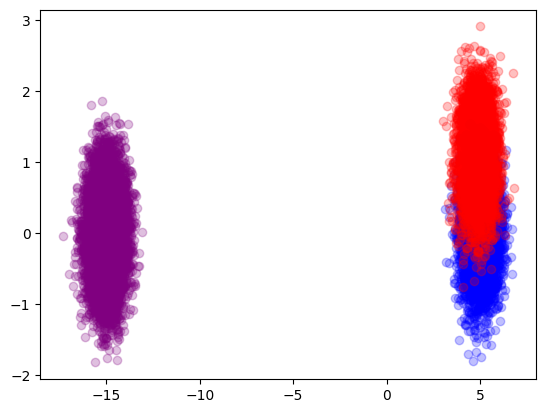

In [7]:
plt.scatter(pi_0[:, 0], pi_0[:, 1], color="purple", alpha=0.25, marker="o")
plt.scatter(pi_1_0[:, 0], pi_1_0[:, 1], color="blue", alpha=0.25, marker="o")
plt.scatter(pi_1_1[:, 0], pi_1_1[:, 1], color="red", alpha=0.25, marker="o")

In [8]:
dataset = Dataset(pi_0, pi_1)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Train Models

In [12]:
fm_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(fm_model.parameters(), lr=5e-3, weight_decay=wd)
fm_loss = train_rectified_flow(fm_model, optimizer, train_dataloader, nb_epochs, eps=1e-15)

100%|██████████| 2000/2000 [01:49<00:00, 18.20it/s]


In [23]:
cf_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(cf_model.parameters(), lr=5e-3, weight_decay=wd)
cf_loss = train_rectified_flow(
    cf_model, optimizer, train_dataloader, nb_epochs, eps=1e-15, 
    contrastive_obj=True, contrastive_lambda=0.5, cc_contrastive_obj=False
)

100%|██████████| 2000/2000 [02:01<00:00, 16.50it/s]


In [9]:
ccf_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(ccf_model.parameters(), lr=5e-3, weight_decay=wd)
ccf_loss = train_rectified_flow(
    ccf_model, optimizer, train_dataloader, nb_epochs, eps=1e-15, 
    contrastive_obj=False, contrastive_lambda=0.5, cc_contrastive_obj=True
)

100%|██████████| 2000/2000 [01:49<00:00, 18.31it/s]


## Create Samplers

In [10]:
def sample_fn(rectified_flow, T, pi_0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        drift_pred = rectified_flow(inp[:, :2], t, inp[:, 2].long())
        next_sample = deepcopy(samples[-1].detach())
        next_sample[0, :, :2] = next_sample[0, :, :2] + drift_pred * 1. / T
        # samples.append((samples[-1] + drift_pred * 1. / T))
        samples += [next_sample]
    return torch.cat(samples)


def cfg_sample_fn(rectified_flow, T, pi_0, cfg_scale=1.0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        drift_pred = rectified_flow(inp[:, :2], t, inp[:, 2].long())
        uncond_drif_pred = rectified_flow(inp[:, :2], t, torch.ones((inp.shape[0]), device=inp.device, dtype=torch.long) * 2)
        next_sample = deepcopy(samples[-1].detach())
        drift_step = uncond_drif_pred + cfg_scale * (drift_pred - uncond_drif_pred)
        next_sample[0, :, :2] = next_sample[0, :, :2] + drift_step * 1. / T
        # samples.append((samples[-1] + drift_pred * 1. / T))
        samples += [next_sample]
    return torch.cat(samples)

## Density Metrics

In [11]:
# test_pi_1_1[:, sample, 0].cpu().detach().numpy().shape
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Compute KDE for density estimation
def compute_kde_density(x, y):
    values = np.vstack([x, y])
    kde = gaussian_kde(values)(values)
    return kde

def compute_vertical_kde_density(y):
    kde = gaussian_kde(y)(y)  # Only using y-values for KDE
    return kde

def compute_y_kde(y_values, y_grid):
    kde = gaussian_kde(y_values, bw_method="scott")  # Estimate density along y
    return kde(y_grid)

In [16]:
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
test_pi_0 = sample_multimodal_distribution(modes, 0.5, batch_size=2000)
test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))

/tmp/ipykernel_48413/3077647200.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))


## Plot BL

In [ ]:

test_pi_1 = sample_fn(fm_model, 1000, torch.from_numpy(test_pi_0).to(device))

test_pi_1_flat = test_pi_1.reshape(-1, 3)
test_pi_1_0 = test_pi_1_flat[test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
test_pi_1_1 = test_pi_1_flat[test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

/tmp/ipykernel_48413/3832427586.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))


In [15]:
x_1_0, y_1_0 = test_pi_1_0[-1, :, 0].cpu().detach().numpy(), test_pi_1_0[-1, :, 1].cpu().detach().numpy()
x_1_1, y_1_1 = test_pi_1_1[-1, :, 0].cpu().detach().numpy(), test_pi_1_1[-1, :, 1].cpu().detach().numpy()

y_min = min(y_1_0.min(), y_1_1.min())
y_max = max(y_1_0.max(), y_1_1.max())
y_grid = np.linspace(y_min, y_max, 500)

density_1_0 = compute_y_kde(y_1_0, y_1_0)
density_1_1 = compute_y_kde(y_1_1, y_1_0)

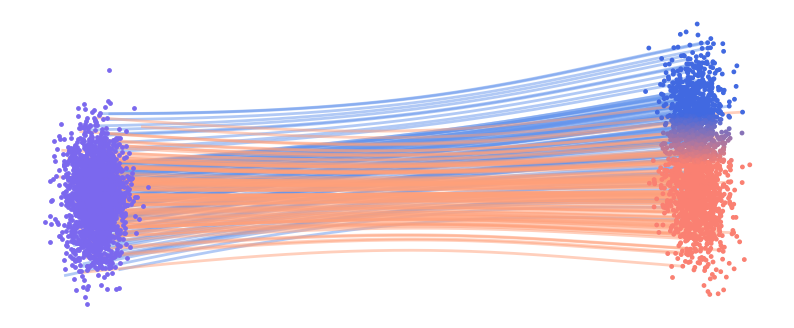

In [18]:
# # make figure size
plt.figure(figsize=(10, 4))

for sample in range(0, test_pi_1_1.shape[1], 10):
    x = test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, test_pi_1_0.shape[1], 10):
    plt.plot(
        test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
# norm = plt.Normalize(
#     test_pi_1_1[-1, :, 1].cpu().detach().numpy().min(),
#     test_pi_1_0[-1, :, 1].cpu().detach().numpy().max(), 
# )
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


## Plot Contrastive Flows

In [ ]:
# test_pi_0

array([[-14.914425  ,   0.84636116,   1.        ],
       [-14.028917  ,  -0.30675063,   0.        ],
       [-14.314353  ,  -0.3234862 ,   1.        ],
       ...,
       [-13.667111  ,   0.40717012,   0.        ],
       [-14.537133  ,   1.0867325 ,   0.        ],
       [-14.70012   ,  -0.07183977,   1.        ]], dtype=float32)

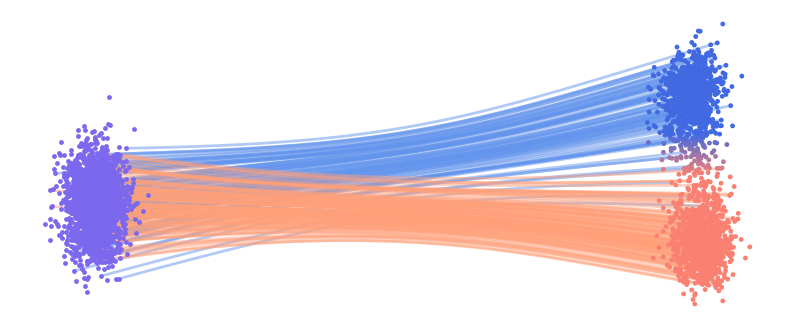

In [32]:
cf_test_pi_1 = sample_fn(cf_model, 1000, torch.from_numpy(test_pi_0).to(device))

cf_test_pi_1_flat = cf_test_pi_1.reshape(-1, 3)
cf_test_pi_1_0 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
cf_test_pi_1_1 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

plt.figure(figsize=(10, 4))

for sample in range(0, cf_test_pi_1_1.shape[1], 10):
    x = cf_test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = cf_test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, cf_test_pi_1_0.shape[1], 10):
    plt.plot(
        cf_test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        cf_test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    cf_test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    cf_test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


## Plot Class Conditioned Contrastive Flows

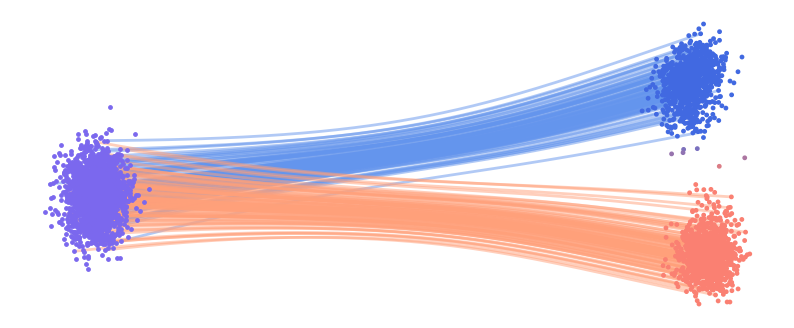

In [17]:
ccf_test_pi_1 = sample_fn(ccf_model, 1000, torch.from_numpy(test_pi_0).to(device))

ccf_test_pi_1_flat = ccf_test_pi_1.reshape(-1, 3)
ccf_test_pi_1_0 = ccf_test_pi_1_flat[ccf_test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
ccf_test_pi_1_1 = ccf_test_pi_1_flat[ccf_test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

plt.figure(figsize=(10, 4))

for sample in range(0, ccf_test_pi_1_1.shape[1], 10):
    x = ccf_test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = ccf_test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, ccf_test_pi_1_0.shape[1], 10):
    plt.plot(
        ccf_test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        ccf_test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()) + .5, 
    vmax=max(density_1_0.max(), density_1_1.max()) + .5
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    ccf_test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    ccf_test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    # c="salmon", 
    alpha=1.0, s=6, zorder=2,
    c=ccf_test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    ccf_test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    ccf_test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    # c="royalblue",
    alpha=1.0, s=6, zorder=2,
    c=ccf_test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
